In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os

## Merge .csv files

In [12]:
all_files = [file for file in os.listdir('./Sales_Data')]

dfs = []
for file in all_files:
    dfs.append(pd.read_csv('./Sales_Data/' + file, index_col=None, header=0))

frame = pd.concat(dfs, ignore_index=True)
frame.to_csv("all_sales_data.csv", index=False)

In [13]:
all_data = pd.read_csv("all_sales_data.csv")
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,295665,Macbook Pro Laptop,1,1700,12/30/19 00:01,"136 Church St, New York City, NY 10001"
1,295666,LG Washing Machine,1,600.0,12/29/19 07:03,"562 2nd St, New York City, NY 10001"
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001"
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016"
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301"


## Clean up

In [14]:
clean_up = all_data.loc[all_data['Order ID'] == 'Order ID'].index.to_list()

all_data.drop(all_data.index[clean_up], inplace=True)

all_data.dropna(inplace=True)

#### Convert columns to correct types

In [15]:
all_data['Quantity Ordered'] = all_data['Quantity Ordered'].astype('int32')
all_data['Price Each'] = all_data['Price Each'].astype('float')

## Augment columns

#### Add month column in int

In [16]:
all_data['Month'] = all_data['Order Date'].str.slice(0,2)
all_data['Month'] = all_data['Month'].astype('int32')

#### Add total sales column

In [17]:
 all_data['Total Sales'] = all_data['Quantity Ordered'] * all_data['Price Each']

#### Add a city column

In [30]:
address_split = all_data['Purchase Address'].str.split(",", n = 3, expand = True)
all_data['Purchase City'] = address_split[1]

## What was the best month for sales?


#### Find month for max total sales

In [31]:
monthly_totals_df = all_data.groupby('Month').sum()
column = monthly_totals_df['Total Sales']
max_total_sales = column.max()

monthly_totals_df.loc[monthly_totals_df['Total Sales'] == max_total_sales]

,Quantity Ordered,Price Each,Total Sales
Month,,,
12,28114,4588415.41,4613443.34




#### Monthly Total Sales Bar Graph

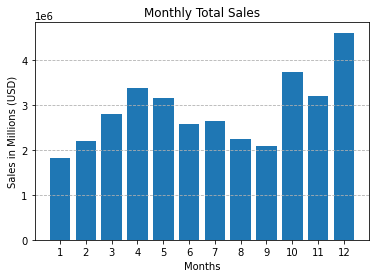

In [32]:
months = range(1,13)
    
plt.bar(months, monthly_totals_df['Total Sales'])

plt.title('Monthly Total Sales')
plt.xlabel('Months')
plt.ylabel('Sales in Millions (USD)')
plt.xticks(months)
plt.grid(axis='y', linestyle='--')
plt.show()

## Which city had the highest amount of sales?

#### Find city for max total sales 

In [36]:
city_totals_df = all_data.groupby('Purchase City').sum()
column1 = city_totals_df['Total Sales']
max_city_sales = column1.max()

city_totals_df.loc[city_totals_df['Total Sales'] == max_city_sales]

,Quantity Ordered,Price Each,Month,Total Sales
Purchase City,,,,
San Francisco,50239,8211461.74,315520,8262203.91


#### Total Sales by City Bar Graph